## Desafío:

Mejora el desempeño de nuestra regressión Lasso **SOLO usando diferentes pasos de ingenería de variables!!**.

El desempeño de nuestro modelo, como puedes ver en este notebook, es el siguiente:
- rmse en el set de prueba: 44798.497576784845
- r2 en el set de prueba: 0.7079639526659389

Para mejorar el desempeño de nuestro modelo debes lograr un r2 en el set de prueba mayor que 0.71 y un rmse en el set de prueba menor que 44798.


### Condiciones:

- No PUEDES cambiar los parámetros del modelo Lasso
- DEBES usar las mismas semillas para la clase Lasso y el método train_test_split como mostramos en el notebook (no cambies los valores del parámetro random_state)
- DEBES usar TODAS las variables del conjunto de datos (a excepción de Id)- NO PUEDES seleccionar variables


### Si mejoras el desempeño de nuestro modelo:

Crea una solicitud de extracción -'pull request'- con tu notebook en este repositorio de github:
https://github.com/solegalli/udemy-ivml-desafio

Recuerda que necesitas primero bifurcar -'fork'- el repositorio, luego cargar tu notebook ganador a tu repositorio y finalmente crear una solicitudes de extracción (PR 'pull request') a nuestro repositorio. Luego revisaremos y fusionaremos tu solicitud, la cual aparecerá en nuestro repo y estará disponible para todos los estudiantes de este curso. De esta forma, otros estudiantes podrán aprender de tu creatividad e ingenio al transformar las variables de este conjunto de datos!

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para el modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# para la ingeniería de variables
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

### Cargar los datos

In [2]:
# cargar los datos

data = pd.read_csv('../houseprice.csv')

In [3]:
# crea una lista de los tipos de variables

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('Hay {} variables continuas '.format(len(numerical)))
print('Hay {} variables discretas'.format(len(discrete)))
print('Hay {} variables temporales'.format(len(year_vars)))
print('Hay {} variables categóricas'.format(len(categorical)))

Hay 18 variables continuas 
Hay 14 variables discretas
Hay 4 variables temporales
Hay 43 variables categóricas


### Separar sets de entrenamiento y prueba 

In [4]:
# IMPORTANTE: 
# manten el random_state igual a zero para poder reproducir los resultados

# Separemos los datos en sets de entrenamiento y prueba 

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculemos el tiempo transcurrido

def elapsed_years(df, var):
    # captura la diferencia entre la variable año var
    # y el año de construcción de la casa
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [6]:
# elimina la variable YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)
year_vars.remove('YrSold')

In [7]:
# captura el nombre de las columnas para usarlas más
# adelante en el notebook
final_columns = X_train.columns

## Pipeline de Ingeniería de Variables

# Desarrollo

Variables Continuas

In [8]:
data[numerical]

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
0,65.0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0
2,68.0,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0
3,60.0,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,0.0,0,0,953,953,953,694,0,1647,460,0,40,0,0,0,0
1456,85.0,13175,119.0,790,163,589,1542,2073,0,0,2073,500,349,0,0,0,0,0
1457,66.0,9042,0.0,275,0,877,1152,1188,1152,0,2340,252,0,60,0,0,0,2500
1458,68.0,9717,0.0,49,1029,0,1078,1078,0,0,1078,240,366,0,112,0,0,0


In [9]:
missing_values_count = data[numerical].isnull().sum()
missing_values_count

LotFrontage      259
LotArea            0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
MiscVal            0
dtype: int64

In [10]:
for var in [var for var in numerical if data[var].isnull().mean() > 0.05] :
    print(var)

LotFrontage


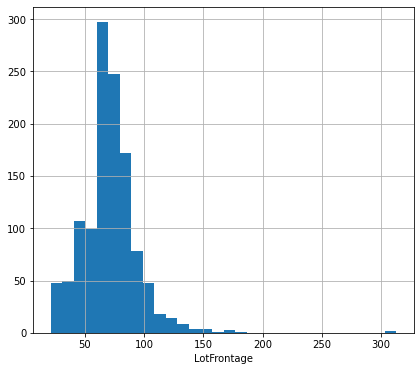

In [11]:
for var in [var for var in numerical if data[var].isnull().mean() > 0.05]:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    data[var].hist(bins=30)
    plt.xlabel(var) 
    plt.show()

In [12]:
for var in [var for var in numerical if data[var].isnull().mean() <= 0.05 and data[var].isnull().sum() > 0] :
    print(var)

MasVnrArea


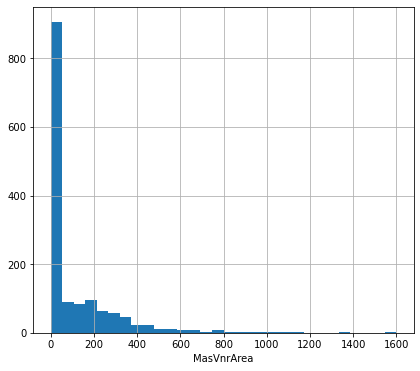

In [13]:
for var in [var for var in numerical if data[var].isnull().mean() <= 0.05 and data[var].isnull().sum() > 0]:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    data[var].hist(bins=30)
    plt.xlabel(var) 
    plt.show()

In [14]:
for var in numerical :
    print(var+" : "+str(len(data[var].unique())))

LotFrontage : 111
LotArea : 1073
MasVnrArea : 328
BsmtFinSF1 : 637
BsmtFinSF2 : 144
BsmtUnfSF : 780
TotalBsmtSF : 721
1stFlrSF : 753
2ndFlrSF : 417
LowQualFinSF : 24
GrLivArea : 861
GarageArea : 441
WoodDeckSF : 274
OpenPorchSF : 202
EnclosedPorch : 120
3SsnPorch : 20
ScreenPorch : 76
MiscVal : 21


In [15]:
variables_numericas_altos_faltantes = ['LotFrontage']

In [16]:
variables_numericas_bajos_faltantes = ['MasVnrArea']

In [17]:
variables_numericas_alta_cardinalidad = ['GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF','LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF']

In [18]:
variables_numericas_baja_cardinalidad = ['BsmtFinSF2','LowQualFinSF','EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal']

Variables Discretas

In [19]:
data[discrete]

,MSSubClass,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold
0,60,7,5,1,0,2,1,3,1,8,0,2,0,2
1,20,6,8,0,1,2,0,3,1,6,1,2,0,5
2,60,7,5,1,0,2,1,3,1,6,1,2,0,9
3,70,7,5,1,0,1,0,3,1,7,1,3,0,2
4,60,8,5,1,0,2,1,4,1,9,1,3,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,5,0,0,2,1,3,1,7,1,2,0,8
1456,20,6,6,1,0,2,0,3,1,7,2,2,0,2
1457,70,7,9,0,0,2,0,4,1,9,2,1,0,5
1458,20,5,6,1,0,1,0,2,1,5,0,1,0,4


In [20]:
missing_values_count = data[discrete].isnull().sum()
missing_values_count

MSSubClass      0
OverallQual     0
OverallCond     0
BsmtFullBath    0
BsmtHalfBath    0
FullBath        0
HalfBath        0
BedroomAbvGr    0
KitchenAbvGr    0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
PoolArea        0
MoSold          0
dtype: int64

In [21]:
for var in discrete :
    print(var+" : "+str(len(data[var].unique())))

MSSubClass : 15
OverallQual : 10
OverallCond : 9
BsmtFullBath : 4
BsmtHalfBath : 3
FullBath : 4
HalfBath : 3
BedroomAbvGr : 8
KitchenAbvGr : 4
TotRmsAbvGrd : 12
Fireplaces : 4
GarageCars : 5
PoolArea : 8
MoSold : 12


In [22]:
variables_discretas_alta_cardinalidad = ['MSSubClass','OverallQual','OverallCond','TotRmsAbvGrd','MoSold']

In [23]:
data[year_vars]

,YearBuilt,YearRemodAdd,GarageYrBlt
0,2003,2003,2003.0
1,1976,1976,1976.0
2,2001,2002,2001.0
3,1915,1970,1998.0
4,2000,2000,2000.0
...,...,...,...
1455,1999,2000,1999.0
1456,1978,1988,1978.0
1457,1941,2006,1941.0
1458,1950,1996,1950.0


In [24]:
missing_values_count = data[year_vars].isnull().sum()
missing_values_count

YearBuilt        0
YearRemodAdd     0
GarageYrBlt     81
dtype: int64

In [25]:
for var in [var for var in year_vars if data[var].isnull().mean() > 0.05 and data[var].isnull().sum() > 0] :
    print(var)

GarageYrBlt


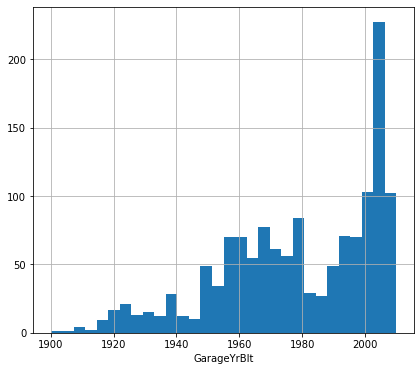

In [26]:
for var in [var for var in year_vars if data[var].isnull().mean() > 0.05 and data[var].isnull().sum() > 0]:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    data[var].hist(bins=30)
    plt.xlabel(var) 
    plt.show()

In [27]:
variables_temporales_altos_faltantes = ['GarageYrBlt']

In [28]:
for var in year_vars :
    print(var+" : "+str(len(data[var].unique())))

YearBuilt : 112
YearRemodAdd : 61
GarageYrBlt : 98


In [29]:
variables_temporales_alta_cardinalidad = ['YearBuilt','GarageYrBlt']

Variables categóricas

In [30]:
data[categorical]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [31]:
missing_values_count = data[categorical].isnull().sum()
missing_values_count

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

In [32]:
for var in [var for var in categorical if data[var].isnull().mean() > 0.05] :
    print(var)

Alley
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PoolQC
Fence
MiscFeature


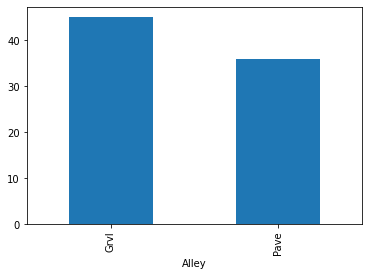

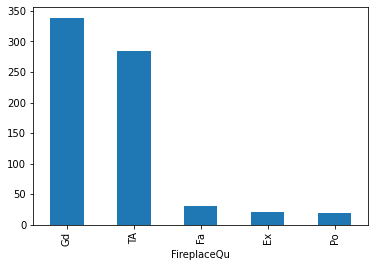

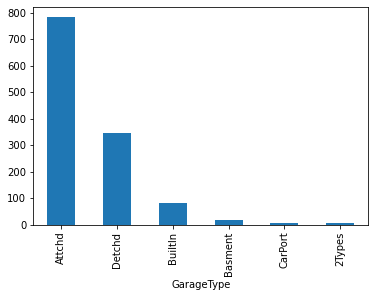

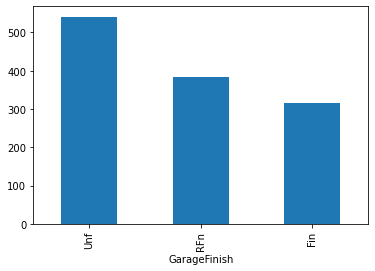

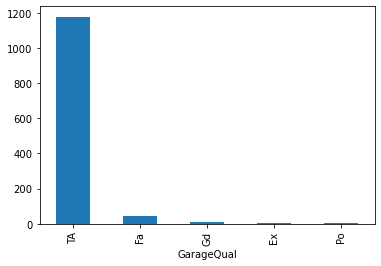

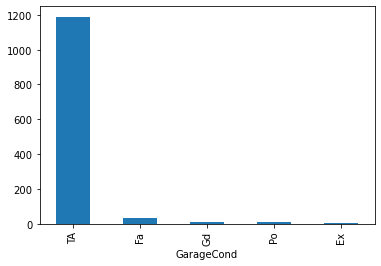

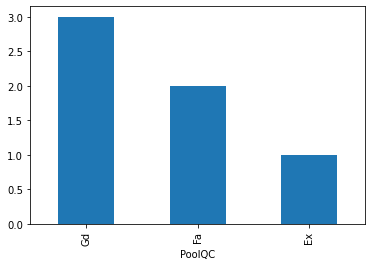

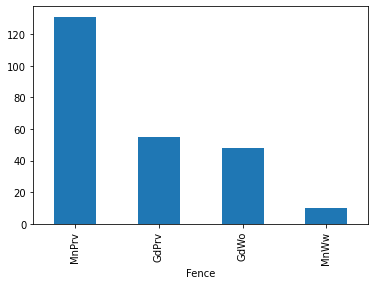

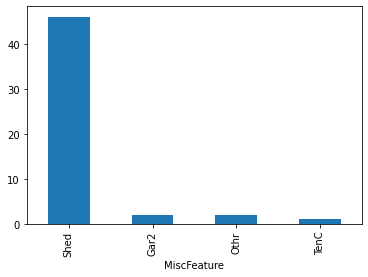

In [33]:
for var in [var for var in categorical if data[var].isnull().mean() > 0.05]:
    X_train[var].value_counts().sort_values(ascending=False).plot.bar()
    plt.xlabel(var)
    plt.show()

In [34]:
for var in [var for var in categorical if data[var].isnull().mean() <= 0.05 and data[var].isnull().sum() > 0] :
    print(var)

MasVnrType
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Electrical


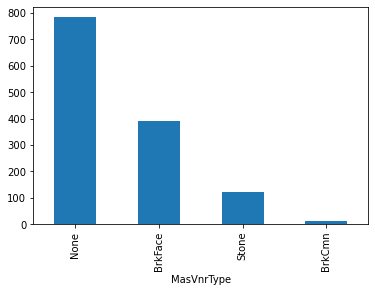

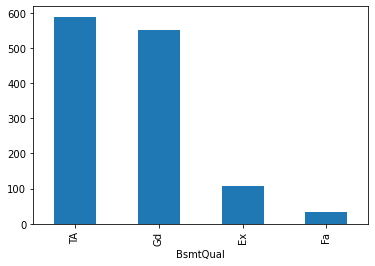

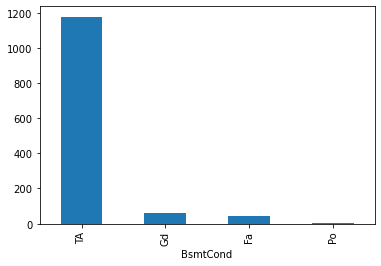

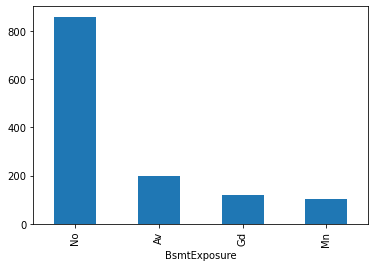

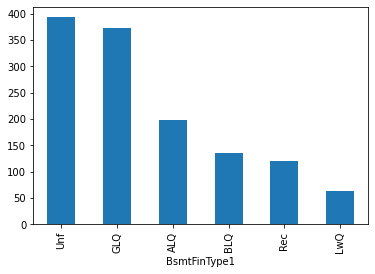

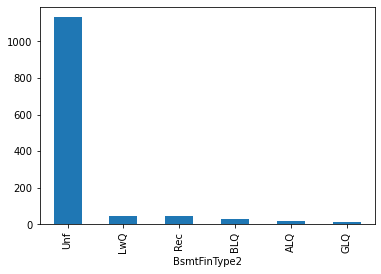

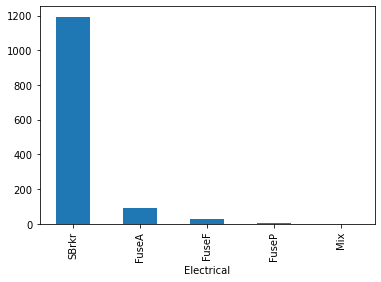

In [35]:
for var in [var for var in categorical if data[var].isnull().mean() <= 0.05 and data[var].isnull().sum() > 0]:
    X_train[var].value_counts().sort_values(ascending=False).plot.bar()
    plt.xlabel(var)
    plt.show()

In [36]:
variables_categoricas_altos_faltantes = ['Alley','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

In [37]:
variables_categoricas_bajos_faltantes = ['MasVnrType','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Electrical']

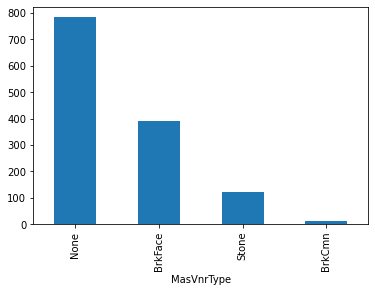

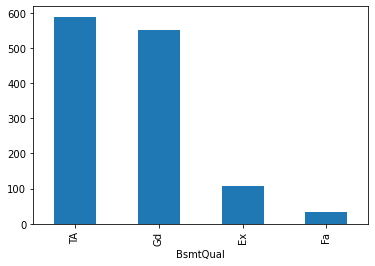

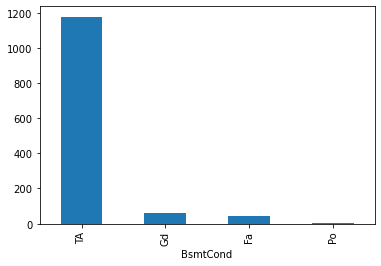

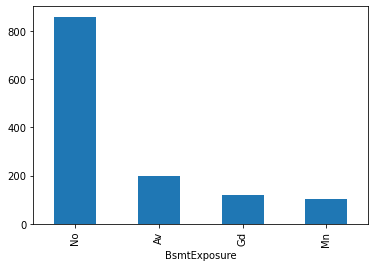

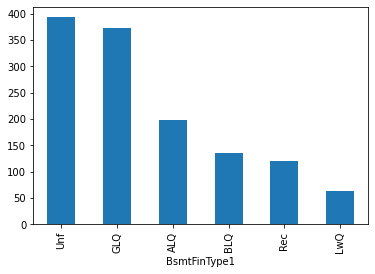

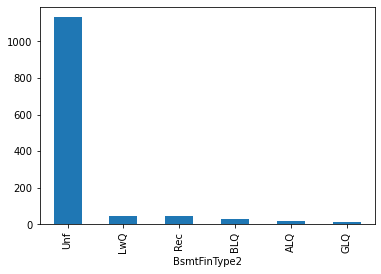

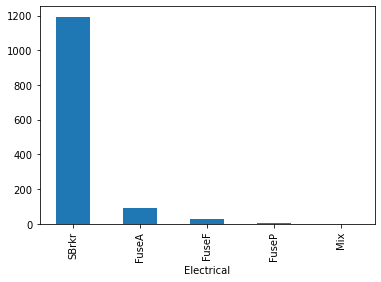

In [38]:
for var in [var for var in categorical if data[var].isnull().sum() > 0 and data[var].isnull().mean() <= 0.05]:
    X_train[var].value_counts().sort_values(ascending=False).plot.bar()
    plt.xlabel(var)
    plt.show()

In [39]:
for var in categorical :
    print(var+" : "+str(len(data[var].unique())))

MSZoning : 5
Street : 2
Alley : 3
LotShape : 4
LandContour : 4
Utilities : 2
LotConfig : 5
LandSlope : 3
Neighborhood : 25
Condition1 : 9
Condition2 : 8
BldgType : 5
HouseStyle : 8
RoofStyle : 6
RoofMatl : 8
Exterior1st : 15
Exterior2nd : 16
MasVnrType : 5
ExterQual : 4
ExterCond : 5
Foundation : 6
BsmtQual : 5
BsmtCond : 5
BsmtExposure : 5
BsmtFinType1 : 7
BsmtFinType2 : 7
Heating : 6
HeatingQC : 5
CentralAir : 2
Electrical : 6
KitchenQual : 4
Functional : 7
FireplaceQu : 6
GarageType : 7
GarageFinish : 4
GarageQual : 6
GarageCond : 6
PavedDrive : 3
PoolQC : 4
Fence : 5
MiscFeature : 5
SaleType : 9
SaleCondition : 6


In [40]:
variables_categoricas_alta_cardinalidad = ['Neighborhood','Exterior1st','Exterior2nd']

In [ ]:
#variables_numericas_altos_faltantes
#variables_numericas_bajos_faltantes
#variables_numericas_alta_cardinalidad
#variables_numericas_baja_cardinalidad

#variables_discretas_alta_cardinalidad

#variables_temporales_altos_faltantes
#variables_temporales_alta_cardinalidad

#variables_categoricas_altos_faltantes
#variables_categoricas_bajos_faltantes
#variables_categoricas_alta_cardinalidad

In [65]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [60]:
missing_values_count = data['MSZoning'].isnull().sum()
missing_values_count

0

In [66]:
house_pipe = Pipeline([

   
    ('imputer_most_frecuent_cat', 
     mdi.CategoricalImputer(imputation_method = 'frequent',                            
                            variables = variables_categoricas_bajos_faltantes)),
    
    ('imputer_missing_cat', 
     mdi.CategoricalImputer(imputation_method = 'missing',
                            variables = variables_categoricas_altos_faltantes)),
    
    ('imputer_random_num', 
     mdi.RandomSampleImputer(random_state = 27,
                             variables = ['LotFrontage'])),
    
    ('imputer_median_num', 
     mdi.MeanMedianImputer(imputation_method = 'median',
                           variables = variables_numericas_altos_faltantes)),
    
    ('imputer_median_num_b', 
     mdi.MeanMedianImputer(imputation_method = 'median',
                           variables = variables_numericas_bajos_faltantes)),
    ('imputer_median_num_t', 
     mdi.MeanMedianImputer(imputation_method = 'median',
                           variables = variables_temporales_altos_faltantes)),
    
   ('encoding',
     ce.OneHotEncoder(variables = categorical,
                     drop_last = True)),
    
      
    ('scaler', StandardScaler()),
    
    
    ('lasso', Lasso(random_state=0))
])

In [67]:
# ajustemos el pipeline - conjunto de pasos de 
# para el pre-procesamiento y modelamiento

house_pipe.fit(X_train, y_train)

# obtengamos las predicciones
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\mailt\.conda\envs\ambienteparaML\lib\site-packages\feature_engine\encoding\one_hot.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[str(feature) + "_" + str(category)] = np.where(
C:\Users\mailt\.conda\envs\ambienteparaML\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198879764955.398, tolerance: 820439508.5822281
  model = cd_fast.enet_coordinate_descent(
C:\Users\mailt\.conda\envs\ambienteparaML\lib\site-packages\feature_engine\encoding\one_hot.py:236: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de

In [68]:
# revisemos desempeño del modelo:

print('mse entrenamiento: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('rmse entrenamiento: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('r2 entrenamiento: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('mse prueba: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('rmse prueba: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('r2 prueba: {}'.format(r2_score(y_test, X_test_preds)))

mse entrenamiento: 396237445.260607
rmse entrenamiento: 19905.713884726843
r2 entrenamiento: 0.9365393794879326

mse prueba: 1219329118.1531355
rmse prueba: 34918.89342681316
r2 prueba: 0.822568588084971
